<a href="https://colab.research.google.com/github/sadrireza/Neural-Networks/blob/main/Multiclass_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy
import gdown
import matplotlib.pyplot as plt

# Define paths
local_path = '/content/ign'  # Adjust this path if you're running locally
online_link = 'https://drive.google.com/uc?id=1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem'  # Update to direct download link
annotations_path = '/content/ign/ign/annotations'
images_path = '/content/ign/ign/images'

# Download and extract dataset if not found locally
if not os.path.exists(local_path):
    print(f"Dataset not found at {local_path}. Downloading from {online_link}...")
    gdown.download(online_link, '/content/dataset.zip', quiet=False)
    with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
        zip_ref.extractall(local_path)
    print("Download and extraction complete.")

In [29]:
# Load images and annotations
def load_images_from_folder(folder, color_mode='rgb'):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(256, 256), color_mode=color_mode)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

# Load training and validation datasets
train_images = load_images_from_folder(os.path.join(images_path, 'training'), color_mode='rgb')
train_annotations = load_images_from_folder(os.path.join(annotations_path, 'training'), color_mode='grayscale')
val_images = load_images_from_folder(os.path.join(images_path, 'validation'), color_mode='rgb')
val_annotations = load_images_from_folder(os.path.join(annotations_path, 'validation'), color_mode='grayscale')

# Normalize images and annotations
train_images = train_images / 255.0
val_images = val_images / 255.0
train_annotations = train_annotations / 255.0
val_annotations = val_annotations / 255.0

# Expand dimensions of annotations to match model output
train_annotations = np.expand_dims(train_annotations.squeeze(), axis=-1)
val_annotations = np.expand_dims(val_annotations.squeeze(), axis=-1)

# Data Augmentation
data_gen_args = dict(rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the flow method for both
seed = 1
image_generator = image_datagen.flow(train_images, batch_size=8, seed=seed)
mask_generator = mask_datagen.flow(train_annotations, batch_size=8, seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# Custom loss function
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [30]:
# Residual Block with Dropout
def res_block(x, filters, kernel_size=3):
    conv = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(conv)
    conv = layers.BatchNormalization()(conv)

    shortcut = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    shortcut = layers.BatchNormalization()(shortcut)

    output = layers.add([conv, shortcut])
    output = layers.Activation('relu')(output)
    output = layers.Dropout(0.3)(output)  # Adjusted dropout
    return output

# ResUNet Model
def resunet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    e1 = res_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(e1)

    e2 = res_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(e2)

    e3 = res_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(e3)

    e4 = res_block(p3, 256)
    p4 = layers.MaxPooling2D((2, 2))(e4)

    e5 = res_block(p4, 512)
    p5 = layers.MaxPooling2D((2, 2))(e5)

    # Bottleneck
    b = res_block(p5, 1024)

    # Decoder
    u1 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, e5])
    d1 = res_block(u1, 512)

    u2 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = layers.concatenate([u2, e4])
    d2 = res_block(u2, 256)

    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = layers.concatenate([u3, e3])
    d3 = res_block(u3, 128)

    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d3)
    u4 = layers.concatenate([u4, e2])
    d4 = res_block(u4, 64)

    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d4)
    u5 = layers.concatenate([u5, e1])
    d5 = res_block(u5, 32)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d5)

    model = models.Model(inputs, outputs)
    return model

model = resunet()
model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss, metrics=['accuracy', dice_loss])

# Learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [31]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    validation_data=(val_images, val_annotations),
    steps_per_epoch=len(train_images) // 8,  # Adjusted for batch size 8
    epochs=20,
    callbacks=[lr_scheduler]
)

Epoch 1/20
75/75 [==============================] - 87s 728ms/step - loss: 2.3263 - accuracy: 0.1024 - dice_loss: 0.9894 - val_loss: 1.2681 - val_accuracy: 0.1217 - val_dice_loss: 0.9896 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 35s 465ms/step - loss: 1.1491 - accuracy: 0.1086 - dice_loss: 0.9902 - val_loss: 1.1283 - val_accuracy: 0.1217 - val_dice_loss: 0.9906 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 34s 454ms/step - loss: 1.0943 - accuracy: 0.1076 - dice_loss: 0.9907 - val_loss: 1.0830 - val_accuracy: 0.1217 - val_dice_loss: 0.9913 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 34s 458ms/step - loss: 1.0725 - accuracy: 0.1080 - dice_loss: 0.9910 - val_loss: 1.0556 - val_accuracy: 0.1217 - val_dice_loss: 0.9938 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 34s 454ms/step - loss: 1.0562 - accuracy: 0.1077 - dice_loss: 0.9912 - val_loss: 1.0483 - val_accuracy: 0.1217 - val_dice_loss: 0.9964 - lr: 0.0010


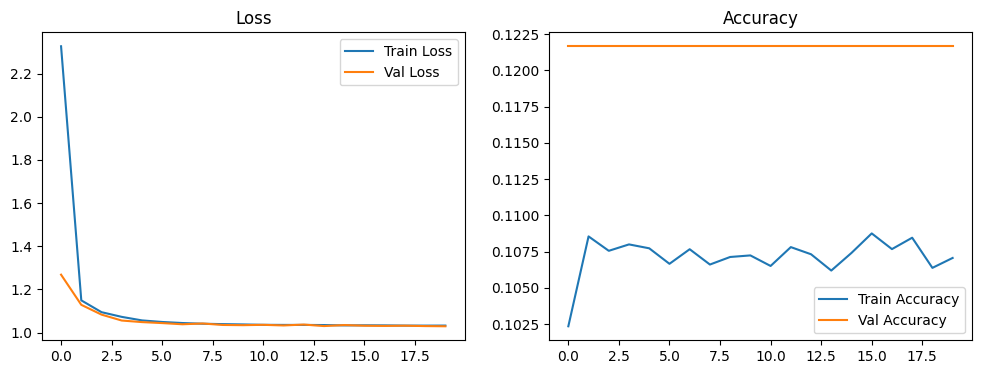

1/1 [==============================] - 0s 21ms/step


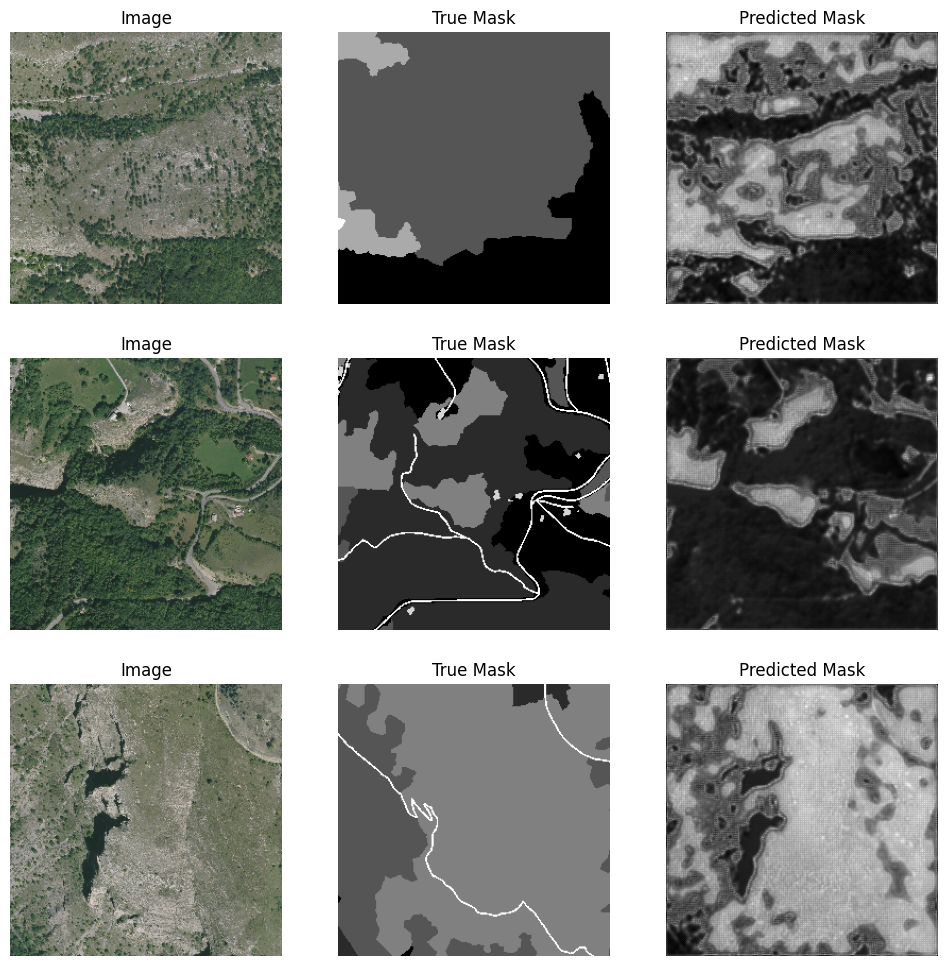

In [32]:
# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Plot some sample predictions
def plot_sample_predictions(model, val_images, val_annotations, num_samples=3):
    sample_indices = np.random.choice(len(val_images), num_samples)
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(sample_indices):
        img = val_images[idx]
        true_mask = val_annotations[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

# Plot sample predictions
plot_sample_predictions(model, val_images, val_annotations)